In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
year=2009
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2009

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

### load observations

In [5]:
dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))

In [6]:
dfSta.head()

,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude
Station,,,,,,
ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933
ADM002,C,Admiralty Inlet (north) - Quimper Pn.,Admiralty Inlet,79,48.187318,-122.842950
ADM003,C,Admiralty Inlet (south),Admiralty Inlet,118,47.878983,-122.483195
BLL009,C,Bellingham Bay - Pt. Frances,Strait of Georgia,31,48.685940,-122.599618
BUD005,C,Budd Inlet - Olympia Shoal,South Basin,22,47.092040,-122.918197


In [7]:
dfCTD0=pickle.load(open(os.path.join(datadir,f'Casts_{str(year)}.p'),'rb'))

In [8]:
dfCTD0.head()

,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Station,Date
0,30.843000,7.5548,24.072300,1.151562,8.184844,0.622280,-136.5,ADM001,2009-04-06
1,30.842699,7.5548,24.072100,1.166062,8.180969,0.643501,-136.0,ADM001,2009-04-06
2,30.842300,7.5547,24.071800,1.128363,8.187900,0.640850,-135.5,ADM001,2009-04-06
3,30.839100,7.5551,24.069300,1.180562,8.196803,0.638222,-135.0,ADM001,2009-04-06
4,30.837999,7.5553,24.068399,1.145762,8.202610,0.636838,-134.5,ADM001,2009-04-06


In [9]:
dfCTD=pd.merge(left=dfSta,right=dfCTD0,how='right',
             left_on='Station',right_on='Station')
#right join means all rows in right table (dfCTD) are included in output
dfCTD.head()

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Date
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.843000,7.5548,24.072300,1.151562,8.184844,0.622280,-136.5,2009-04-06
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.842699,7.5548,24.072100,1.166062,8.180969,0.643501,-136.0,2009-04-06
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.842300,7.5547,24.071800,1.128363,8.187900,0.640850,-135.5,2009-04-06
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.839100,7.5551,24.069300,1.180562,8.196803,0.638222,-135.0,2009-04-06
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.837999,7.5553,24.068399,1.145762,8.202610,0.636838,-134.5,2009-04-06


In [10]:
# check that there are no stations without lat and lon:
dfCTD.loc[pd.isnull(dfCTD['Latitude'])]

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Date


In [11]:
# check one to one matches:
len(dfCTD),len(dfCTD0), len(dfSta)

(45772, 45772, 39)

In [12]:
# where no time is provided, set time to midday Pacific time = ~ 20:00 UTC for now
# (most sampling takes place during the day)
# accurate times will be provided at a later date
# the code below takes advantage of all elements in 'Date' having a time component 
# set to midnight
dfCTD['dtUTC']=[iiD+dt.timedelta(hours=20) for iiD in dfCTD['Date']]

In [13]:
# We require the following columns:
#    dtUTC datetime
#    Lat   Latitude
#    Lon   Longitude
#    Z     Depth, increasing downward (positive)
dfCTD.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
dfCTD['Z']=-1*dfCTD['Z']
dfCTD.head()

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Date,dtUTC
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.843000,7.5548,24.072300,1.151562,8.184844,0.622280,136.5,2009-04-06,2009-04-06 20:00:00
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.842699,7.5548,24.072100,1.166062,8.180969,0.643501,136.0,2009-04-06,2009-04-06 20:00:00
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.842300,7.5547,24.071800,1.128363,8.187900,0.640850,135.5,2009-04-06,2009-04-06 20:00:00
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.839100,7.5551,24.069300,1.180562,8.196803,0.638222,135.0,2009-04-06,2009-04-06 20:00:00
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.837999,7.5553,24.068399,1.145762,8.202610,0.636838,134.5,2009-04-06,2009-04-06 20:00:00


In [14]:
# Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
# Salinity (psu) and Temperature (deg C):
press=gsw.p_from_z(-1*dfCTD['Z'],dfCTD['Lat'])
dfCTD['SA']=gsw.SA_from_SP(dfCTD['Salinity'],press,
                           dfCTD['Lon'],dfCTD['Lat'])
dfCTD['CT']=gsw.CT_from_t(dfCTD['SA'],dfCTD['Temperature'],press)

In [15]:
print(len(dfCTD),'data points')
print('Number of data points in each region:')
dfCTD.groupby('Basin')['SA'].count()

45772 data points
Number of data points in each region:


Basin
Admiralty Inlet            6034
Grays Harbor                323
Hood Canal Basin           2520
Main Basin                11951
South Basin                7128
Strait of Georgia          3715
Strait of Juan de Fuca     9077
Whidbey Basin              4284
Willapa Bay                 740
Name: SA, dtype: int64

### set up variables for model-data matching

In [16]:
# start_date and end_date are the first and last dates that will 
#  be included in the matched data set
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'vosaline':'grid_T','votemper':'grid_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'ptrc_T':1,'grid_T':1}
# Note: to switch between 201812 and 201905 model results, change PATH
# to switch from hourly to daily model output, change fdict values from 1 to 24 (but daily 
#  files are not available for some runs and file types)

In [17]:
data=et.matchData(dfCTD,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.68732166666667 -123.74988166666667  not matched to domain
(Lat,Lon)= 46.703986666666665 -123.837385  not matched to domain
(Lat,Lon)= 46.937313333333336 -123.91322333333333  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 46.97787 -123.78461  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain
progress: 0.0%
progress: 11.242523721725053%
progress: 22.485047443450107%
progress: 33.727571165175156%
progress: 44.97009488690021%
progress: 56.21261860862526%
progress: 67.45514233035031%
progress: 78.69766605207536%
progress: 89.94018977380043%


In [32]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

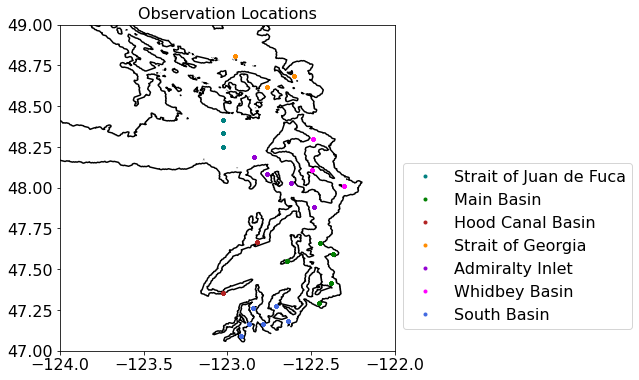

In [33]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [34]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [35]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Strait of Juan de Fuca', 'Main Basin', 'Hood Canal Basin', 'Strait of Georgia', 'Admiralty Inlet', 'Whidbey Basin', 'South Basin'])

# Absolute Salinity (g/kg)

In [36]:
obsvar='SA'
modvar='mod_vosaline'
statsDict={year:dict()}
statsDict[year]['SA']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['SA'][isub]=dict()
    var=statsDict[year]['SA'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['SA'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Strait of Juan de Fuca
Main Basin
Hood Canal Basin
Strait of Georgia
Admiralty Inlet
Whidbey Basin
South Basin


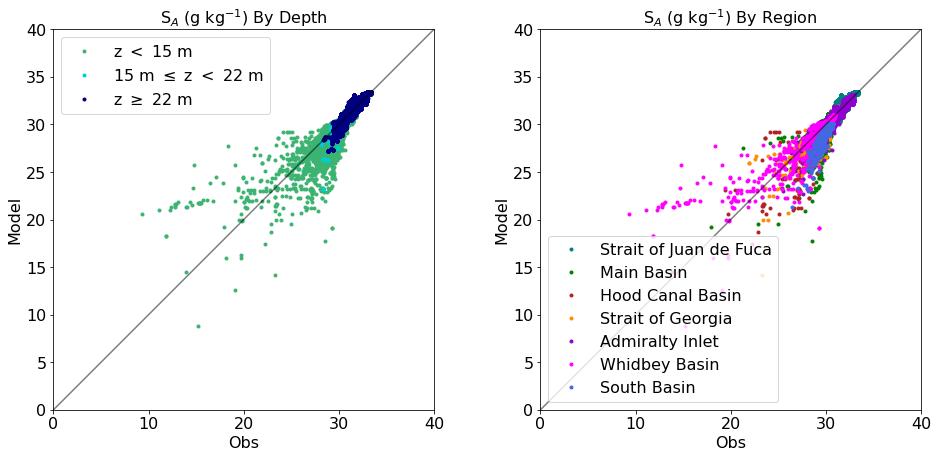

In [37]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,40))
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

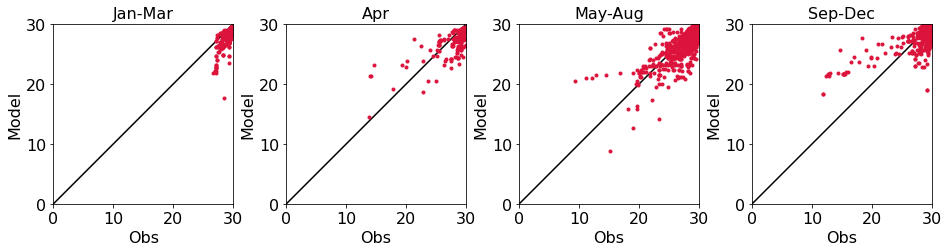

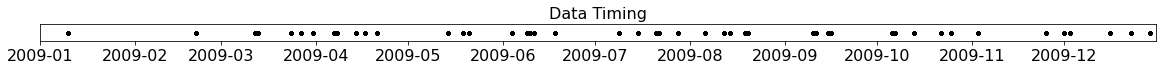

In [38]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

# Conservative Temperature

In [39]:
obsvar='CT'
modvar='mod_votemper'
statsDict[year]['CT']=OrderedDict()
for isub in statsubs:
    statsDict[year]['CT'][isub]=dict()
    var=statsDict[year]['CT'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['CT'],level='Subset',suborder=list(statsubs.keys()))
tbl

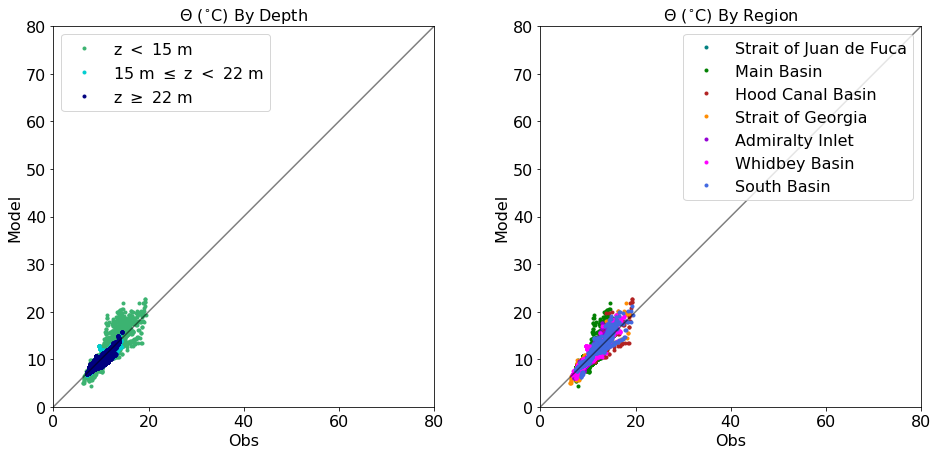

In [40]:
mv=(0,80)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

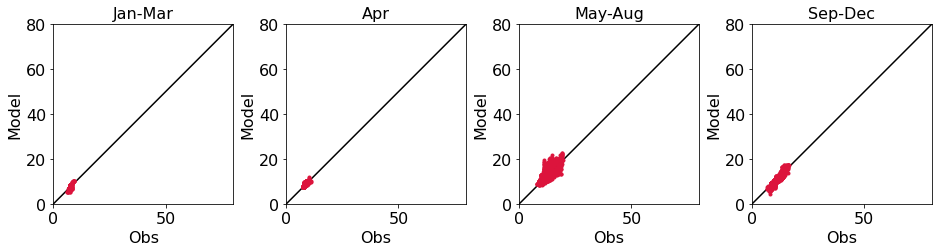

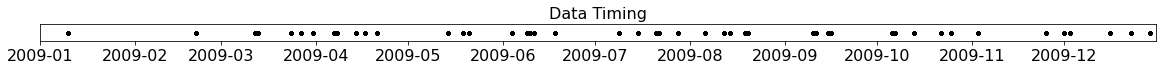

In [41]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

In [42]:
### Temperature-Salinity by Region

In [43]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,20)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps=list()
    for ind, iregion in enumerate(data.Basin.unique()):
        p=ax.plot(datreg[iregion][svar], datreg[iregion][tvar],'.',
                color = colors[ind], label=iregion)
        ps.append(p[0])
    l=ax.legend(handles=ps,bbox_to_anchor=(1.01,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

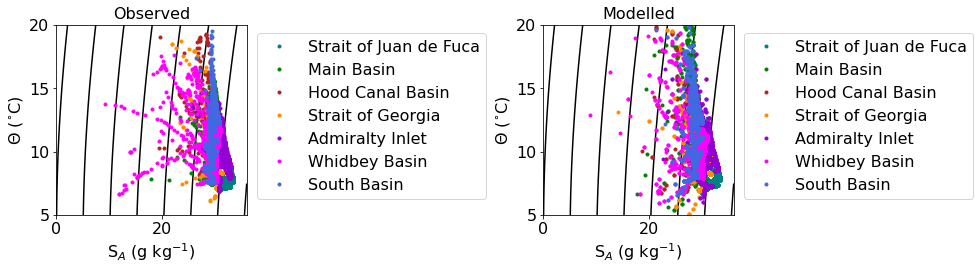

In [44]:
fig,ax=plt.subplots(1,2,figsize=(16,3.5))
tsplot(ax[0],'SA','CT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

In [45]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl